In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import spacy
import emoji
import nltk
#import spacy_udpipe
#nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize , RegexpTokenizer
from nltk.stem import SnowballStemmer
#from nltk.stem.isri import ISRIStemmer
#from nltk.stem import WordNetLemmatizer
import qalsadi.lemmatizer
#from nltk.stem.snowball import FrenchStemmer
#from transformers import pipeline
from langdetect import detect_langs, DetectorFactory,LangDetectException
#from tashaphyne.stemming import ArabicLightStemmer
from fuzzywuzzy import fuzz,process
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from transformers import BertModel, BertTokenizer


C:\Users\BIGNETWORK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df0=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/resaux_comments.xlsx")
df1=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/hateonly_mehdi.xlsx")
df2=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/fb_comments.xlsx")
df3=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/hainer_ranim.xlsx")
df4=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/neutre_mehdi.xlsx")
df5=pd.read_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/datasets/newest.xlsx")

In [3]:
df = pd.concat([df0, df1, df2, df3,df4,df5], axis=0, ignore_index=True)

In [4]:
df = df.sample(frac=1).reset_index(drop=True)
df

,comments,class
0,اذا قعدت تدير على جيزي مرة الجاي تصور فيديو به...,0.0
1,جمعة جمعة وكمل الباك مي نكما.تكم,NaN
2,النزاهة؟؟ و النزاهة في الخدمات و حق المشتركين ...,0.0
3,Votre réseau est devenu médiocre malheureusement,0.0
4,اكيد ما حبش يرجع الأموال المنهوبة التي ينتظرها...,1.0
...,...,...
18458,غير الخرطي والكذب مكان والو غير تفلكسي يسرقولك...,0.0
18459,ني صحة عيدكم ني شكوبي سراقين ياناس اخطاكم من ج...,-1.0
18460,إنقطاع في تغطية شبكة الهاتف النقال مناطق في ...,0.0
18461,Kraht djizi mn l3bd adha saamt yo9tl,1.0


In [169]:
df.to_excel("C:/Users/BIGNETWORK/Desktop/PFE/dataset/dataset.xlsx")

In [5]:
df=df.dropna(subset = ['comments'])

In [6]:
df['comments'].isna().sum()

0

*** 
---
___

## <span style='font-family:Georgia'> Preprocessing of Text.

### <span style='font-family:serif'> Function to Remove Emojis

In [7]:
def strip_emoji(text):
    return emoji.replace_emoji(text,replace="")

### <span style='font-family:serif'> Removing stop words

In [8]:
# Load stopwords for each language
with open('C:/Users/BIGNETWORK/Desktop/PFE/dataset/project/git-one/Algerian-Arabic-stop-words.txt', 'r', encoding='utf-8') as f:
    stop_words_ar_dz = set([line.strip() for line in f])
stop_words_en = set(stopwords.words('english'))
stop_words_fr = set(stopwords.words('french'))
# Create a custom tokenizer for Arabic words
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
# Define a function to remove stop words from a text
def remove_stopwords(text):
    words = tokenizer.tokenize(text)
    words_filtered = []
    for word in words:
        if word not in stop_words_ar_dz and word not in stop_words_en and word not in stop_words_fr:
            words_filtered.append(word)
    return ' '.join(words_filtered)


### <span style='font-family:serif'> Fucntion to remove special characters, URLs, duplicated letters, punctuations

In [9]:
# Define a function to perform the text cleaning operations
def clean_text(text):
    text = re.sub(r'[\r\n]+', ' ', text).lower()  
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #URLs
    #text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation marks 
    text = re.sub(r'\b\d+\b', '', text) # Remove only standalone numbers
    text = re.sub(r'[@#&$]\w+', '', text)  # Remove special characters
    text = re.sub(r'(\w{1})(\1{2,})', r'\1', text) # remove duplicated letters
    return text

In [10]:
print(clean_text('ان.من.نفلكسي.لا.1500.ولا.1000.الف.لان.وينروح.انقبض.الانترانت.بطل.'))

ان من نفلكسي لا  ولا  الف لان وينروح انقبض الانترانت بطل 


### <span style='font-family:serif'> Function to remove mutiple sequence spaces

In [11]:
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

### <span style='font-family:serif'> Function for language detection

In [12]:
DetectorFactory.seed = 0  # Set the random seed for reproducibility
# Set the detection threshold to 0.7
DetectorFactory.threshold = 0.7
def lang_det(texte):
    try:
        langs = detect_langs(texte)
        for lang in langs:
            if lang.prob >= 0.999994:
                langage = lang.lang
            else:
                langage = 'dz'
        if langage not in ['en','fr']:
            langage = 'dz'
    except LangDetectException:
        langage = 'dz'
    
    return langage

In [13]:
print(lang_det('Je ne sais pas pourquoi.  Ça marche très bien sauf le vendredi a partir de 13h  le moment du hirak . C  un problème.'))

fr


### <span style='font-family:serif'> Fonction that translate from Arabizi to Algerian Arabic alphabet using mapping dictionary

In [14]:
# Define the mapping dictionary
mapping = {
    'eau':'و','ai':'ي','ae':'ع','a': 'ا','cc':'ك','ca':'ك','co':'ك', 'gh':'غ', 'kh':'خ','sh':'ش',
    'ch':'ش','dj':'ج','g': 'ڨ', 'h': 'ه', 'i': 'ي', 'j': 'ج', 'k': 'ك', 'l': 'ل','e': '', 'f': 'ف',
    'm': 'م', 'n': 'ن', 'ou': 'و', 'o': 'و', 'p': 'ب', 'q': 'ق', 'r': 'ر','d': 'د',
    's': 'ص', 't': 'ت', 'u': 'ي', 'v': 'ڥ', 'w': 'و', 'x': 'كس','b': 'ب', 'c': 'س',
    'y': 'ي', 'z': 'ز','9':'ق','7':'ح','é':'ي','3':'ع','1':'يا','5':'خ',
}
# Define the translation function
def arabizi_to_arabic(text):
    # Replace each Arabizi letter with its corresponding Arabic alphabet dialect letter
    for letter, value in mapping.items():
        text = re.sub(letter, value, text)
    return text

# Example usage
arabizi_text = "naflixy w cnx t3oul 3lah win rahi lfayda cnx rahi vrai t3ayii réseau matgtouch tsagmouh wlh ila 3ayb 3likoum "
arabic_text = arabizi_to_arabic(arabizi_text)
print(arabic_text)

نافليكسي و سنكس تعول علاه وين راهي لفايدا سنكس راهي ڥري تعاييي ريصو ماتڨتوش تصاڨموه وله يلا عايب عليكوم 


### <span style='font-family:serif'> Function to  apply stemming to words

In [15]:
def stem_words(text):
    language = lang_det(text)
    stemmer = None
    words = tokenizer.tokenize(text)
    if language == 'dz':
        text=arabizi_to_arabic(text)
        stemmed_text = text
    elif language == 'fr':
        stemmer = SnowballStemmer('french')
        stemmed_words = [stemmer.stem(word) for word in words]
        stemmed_text = ' '.join(stemmed_words)
    elif language == 'en':
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in words]
        stemmed_text = ' '.join(stemmed_words)
    else:
        return text # No stemmer available for this language
    
    return stemmed_text

### <span style='font-family:serif'> Function to apply lemmatization to words

In [24]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BIGNETWORK\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BIGNETWORK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:

nlp_en = spacy.load('en_core_web_sm')
nlp_fr = spacy.load('fr_core_news_sm')
def lemmatize(text):
    # Tokenize the text
    words = tokenizer.tokenize(text)

    # Define lemmatizer for each language
    lemma_dz = qalsadi.lemmatizer.Lemmatizer()
    # Lemmatize each word in the text
    lemmatized_words = []
    lang = lang_det(text)
    if lang =='en':
        doc = nlp_en(text)
        for token in doc:
            lemma = token.lemma_
            lemmatized_words.append(lemma)
    elif lang =='fr':
        doc = nlp_fr(text)
        for token in doc:
            lemma = token.lemma_
            lemmatized_words.append(lemma)
    elif lang =='dz':
        for word in words:
            lemma = lemma_dz.lemmatize(word)
            lemmatized_words.append(lemma)
    
    # Join the lemmatized words to form the lemmatized text
    lemmatized_text = ' '.join(lemmatized_words)
    
    return lemmatized_text

### <span style='font-family:serif'> Function to Preprocess the text by applying all above functions

In [17]:
def preprocess1(text):
    text = strip_emoji(text)
    text = clean_text(text)
    text = remove_mult_spaces(text)
    return text


In [18]:
def preprocess2(text):
    text = stem_words(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    return text

In [98]:
if df['comments'].dtype == 'object':
    df['comments_clean'] = df['comments'].apply(preprocess1)

In [19]:
if df1['comments'].dtype == 'object':
    df1['comments_clean'] = df1['comments'].apply(preprocess1)

In [99]:
df['comments_clean'].replace('', np.nan, inplace=True)
missing_values = df[df['comments_clean'].isnull()]
#df=df.dropna(subset = ['comments_clean'])
len(missing_values)

0

In [20]:
df1['comments_clean'].replace('', np.nan, inplace=True)
missing_values = df1[df1['comments_clean'].isnull()]
#df=df.dropna(subset = ['comments_clean'])
len(missing_values)

9

In [100]:
df=df.dropna(subset = ['comments_clean'])

In [21]:
df1=df1.dropna(subset = ['comments_clean'])

In [22]:
df1

,comments,class,comments_clean
0,Conx ta3koum dayra ki lhaaaam w say,1,conx ta3koum dayra ki lham w say
1,@djezzy.dz connection khraaaaa welat,-1,connection khra welat
2,Barkawna bla 5orti cnx ta3kom dayra kile5ra,-1,barkawna bla 5orti cnx ta3kom dayra kile5ra
3,Conx merdique,1,conx merdique
4,cnx dyalkom ki zbl 7acha l3ibad li chafo l cmntr,-1,cnx dyalkom ki zbl 7acha l3ibad li chafo l cmntr
...,...,...,...
352,Kadabiin 🖕🖕🖕🖕🖕🖕🖕🖕🖕🖕,-1,kadabiin
353,@sami_mo0 ils nous ont arnaqué hchawhalna 😒😒,1,ils nous ont arnaqué hchawhalna
354,Waraah conx ya thahnaa warahiiii,-1,waraah conx ya thahnaa warahi
355,Réseau 9r3a 😒😒 3ndi djezzy c vr des offres mla...,1,réseau 9r3a 3ndi djezzy c vr des offres mlah m...


### <span style='font-family:serif'> Regroupement et traitement de fautes d’orthographe

In [23]:
# function to get soundex code for a given word
def get_soundex(word):
    code = ''
    for char in word.upper():
        if char in ['B', 'F', 'P', 'V']:
            code += '1'
        elif char in ['C', 'G', 'J', 'K', 'Q', 'S', 'X', 'Z']:
            code += '2'
        elif char in ['D', 'T']:
            code += '3'
        elif char == 'L':
            code += '4'
        elif char in ['M', 'N']:
            code += '5'
        elif char == 'R':
            code += '6'
        else:
            code += '0'
    return code

# set threshold for similarity score
threshold =88
fuzzy_threshold = 90

# create dictionary to hold fuzzywuzzy scores and their associated words
fuzzy_dict = {}

# create dictionary to hold soundex codes and their associated words
code_dict = {}

# iterate over all words in the comments
for comment in df1['comments_clean']:
    words = tokenizer.tokenize(comment)
    for word in words:
        # check if word is in Arabic script or not
        if any('\u0600' <= c <= '\u06FF' for c in word):
            continue  # skip Arabic words
        # calculate soundex code for the word
        code = get_soundex(word)
        # add word to the dictionary
        if code in code_dict:
            code_dict[code].append(word)
        else:
            code_dict[code] = [word]
        
        # calculate fuzzywuzzy score for the word
        fuzzy_scores = process.extract(word, words)
        for score, match in fuzzy_scores:
            if isinstance(score, (int, float)) and score >= fuzzy_threshold and match != word:
                if word in fuzzy_dict:
                     fuzzy_dict[word].append(match)
                else:
                     fuzzy_dict[word] = [match]
            
# create dictionary to hold word replacements
replace_dict = {}

# iterate over all soundex codes and associated words
for code, words in code_dict.items():
    # skip codes with only one word
    if len(words) == 1:
        continue
    # compare all pairs of words with the same code
    for i in range(len(words)):
        for j in range(i+1, len(words)):
            score = fuzz.token_sort_ratio(words[i], words[j])
            # if the similarity score is above the threshold, add the word pair to the replacement dictionary
            if score >= threshold:
                replace_dict[words[i]] = words[j]
                replace_dict[words[j]] = words[i]

# iterate over all comments and replace words with their soundex group words
for i in range(len(df1)):
    #print(df.loc[i, 'comments_clean'])
    try:
        words =tokenizer.tokenize(df1.loc[i, 'comments_clean'])
        for j in range(len(words)):
            # check if word is in Arabic script or not
            if any('\u0600' <= c <= '\u06FF' for c in words[j]):
                continue  # skip Arabic words
            # calculate soundex code for the word
            code = get_soundex(words[j])
            # check if the code has associated words
            if code in code_dict:
                # check if the word has a replacement
                if words[j] in replace_dict:
                    words[j] = replace_dict[words[j]]
                else:
                    # check if any of the associated words have a replacement
                    for word in code_dict[code]:
                        if word in replace_dict:
                            words[j] = replace_dict[word]
                            break
    except:
        continue
    # join the words back into a string and replace the comment in the dataframe
    df1.loc[i, 'comments_corr'] = ' '.join(words)
    # check if 'comments_corr' is NaN and set it to original value

    '''if not pd.isna(df.loc[i, 'comments_clean']):
        df.loc[i, 'comments_corr'].replace(df.loc[i, 'comments_clean'], np.nan, inplace=True)
'''
df1['comments_corr'].fillna(df1['comments_clean'], inplace=True)

In [26]:
df1.sample(20)

,comments,class,comments_clean,comments_corr
197,هدا رجعتو عليه ياسراقين,-1,هدا رجعتو عليه ياسراقين,هدا رجعتو عليه ياسراقين
2,Barkawna bla 5orti cnx ta3kom dayra kile5ra,-1,barkawna bla 5orti cnx ta3kom dayra kile5ra,barkawna bla 5orti cnx ta3kom dayra kile5ra
95,Roho t9wdo hdi conx hdi t3yo bikom ba djezzy t...,-1,roho t9wdo hdi conx hdi t3yo bikom ba djezzy t...,roho t9wdo hdi conx hdi t3yo bikom fi djezzy t...
37,ماكانش انترنات يا السراقين,-1,ماكانش انترنات يا السراقين,ماكانش انترنات يا السراقين
146,Djezzy سراقيين باقي يومين على الفاتورة تخلصوا ...,-1,djezzy سراقيين باقي يومين على الفاتورة تخلصوا ...,djezzy سراقيين باقي يومين على الفاتورة تخلصوا ...
314,وعلاش كونكسيو تاعكم تقيل تعايو راهج,-1,وعلاش كونكسيو تاعكم تقيل تعايو راهج,وعلاش كونكسيو تاعكم تقيل تعايو راهج
70,Nik matkoum kamel ki djezzy ki oredoo ki mobil...,-1,nik matkoum kamel ki djezzy ki oredoo ki mobil...,nik matkoum kamel ki djezzy ki oredoo ki mobil...
103,تربحو شعر كونكسيو كي شعر نتوما كي شعر يخي شكوبي,1,تربحو شعر كونكسيو كي شعر نتوما كي شعر يخي شكوبي,تربحو شعر كونكسيو كي شعر نتوما كي شعر يخي شكوبي
218,ياو ملي فليكسيت وانا ندعي عليكم او قريب يخلاص ...,1,ياو ملي فليكسيت وانا ندعي عليكم او قريب يخلاص ...,ياو ملي فليكسيت وانا ندعي عليكم او قريب يخلاص ...
161,كنت راح نشري جيزي قريت التعليقات بدلت رايي نكر...,1,كنت راح نشري جيزي قريت التعليقات بدلت رايي نكر...,كنت راح نشري جيزي قريت التعليقات بدلت رايي نكر...


In [ ]:
if df['comments'].dtype == 'object':
    df['comments_clean'] = df['comments_corr'].apply(preprocess2)

In [27]:
if df1['comments'].dtype == 'object':
    df1['comments_clean'] = df1['comments_corr'].apply(preprocess2)

### <span style='font-family:serif'> Dealing with Duplicates

In [190]:
df["comments_clean"].duplicated().sum()

0

In [28]:
df1["comments_clean"].duplicated().sum()

17

In [191]:
df= df.drop_duplicates(subset=["comments_clean"], keep="first")

In [29]:
df1= df1.drop_duplicates(subset=["comments_clean"], keep="first")

#### <span style='font-family:serif'>Duplicates removed

### <span style='font-family:serif'> Tokenization

In [31]:
tokenizer = RegexpTokenizer(r'\w+')
def tokenization(text):
    words=tokenizer.tokenize(text)
    return words

In [88]:
df['comments_clean']=df['comments_clean'].apply(str)
if df['comments_clean'].dtype == 'object':
    df['comments_list'] = df['comments_clean'].apply(tokenization)
df.sample(20)

C:\Users\BIGNETWORK\AppData\Local\Temp\ipykernel_14068\3791954718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comments_clean']=df['comments_clean'].apply(str)
C:\Users\BIGNETWORK\AppData\Local\Temp\ipykernel_14068\3791954718.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comments_list'] = df['comments_clean'].apply(tokenization)


,comments,class,comments_clean,comments_list
1033,تكذب ومتحشمش لنترنت كامل مكاش,NaN,تكذب ومتحشمش لنترنت كامل,"[تكذب, ومتحشمش, لنترنت, كامل]"
94,صباح الخير هذا وين راهم قريب يكملوا الباك عاد ...,NaN,صباح خير راهم قريب كمل الباك عاد خبرتونا,"[صباح, خير, راهم, قريب, كمل, الباك, عاد, خبرتونا]"
2238,Arafat Abdallaoui ايه,0.0,ارافات ابدالاوي ايه,"[ارافات, ابدالاوي, ايه]"
903,Slm chkoun ya3tini Num ta3 khadamat Djezzy ran...,0.0,صلم شكا ياعتيني نيم خادامات دجزي ران ماحتاجاتو...,"[صلم, شكا, ياعتيني, نيم, خادامات, دجزي, ران, م..."
4260,سقمو غير حق الناس امنبعد تبرعو حقنا امديهناش ب...,NaN,سقم حق ناس امنبعد تبرع حق امديهناش باغي تصدق,"[سقم, حق, ناس, امنبعد, تبرع, حق, امديهناش, باغ..."
5846,ننصحكم بجيزي هبال,NaN,نصح جيزة هبال,"[نصح, جيزة, هبال]"
9207,الخروج من بلاد بوصبع الهايشة,1.0,خروج بلاد بوصبع الهايشة,"[خروج, بلاد, بوصبع, الهايشة]"
4497,المقاطعة هي الحل,NaN,مقاطع حل,"[مقاطع, حل]"
4192,zid 3aytlo l3abdo khouya o sam3olhom klmate,NaN,زيد عايتلو عابد خوى صامعولهوم لمة,"[زيد, عايتلو, عابد, خوى, صامعولهوم, لمة]"
2996,@lo.uz wsh mn ma puce khoya yarham waldik,0.0,باس خوى يارهام ديك,"[باس, خوى, يارهام, ديك]"


In [32]:
df1['comments_clean']=df1['comments_clean'].apply(str)
if df1['comments_clean'].dtype == 'object':
    df1['comments_list'] = df1['comments_clean'].apply(tokenization)
df1.sample(10)

C:\Users\BIGNETWORK\AppData\Local\Temp\ipykernel_12432\1621538110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['comments_clean']=df1['comments_clean'].apply(str)
C:\Users\BIGNETWORK\AppData\Local\Temp\ipykernel_12432\1621538110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['comments_list'] = df1['comments_clean'].apply(tokenization)


,comments,class,comments_clean,comments_corr,comments_list
137,على الكونيكسيوا الزينة تاعكم الله يذلكم,-1,الكونيكسيوا زين تاع الله أذل,على الكونيكسيوا الزينة تاعكم الله يذلكم,"[الكونيكسيوا, زين, تاع, الله, أذل]"
24,خخخخخ😂 كونيكسيو كي سلحفاة وزيد تدخل لليوتيوب ت...,-1,خ كونيكسيو سلحفاة زيد تدخل لليوتيوب تفرج فيديو...,خ كونيكسيو كي سلحفاة وزيد تدخل لليوتيوب تتفرج ...,"[خ, كونيكسيو, سلحفاة, زيد, تدخل, لليوتيوب, تفر..."
103,تربحو شعر كونكسيو كي شعر نتوما كي شعر يخي شكوبي,1,تربح شعر كونكسيو شعر نتوما شعر وخى شكوبي,تربحو شعر كونكسيو كي شعر نتوما كي شعر يخي شكوبي,"[تربح, شعر, كونكسيو, شعر, نتوما, شعر, وخى, شكوبي]"
37,ماكانش انترنات يا السراقين,-1,انترنات سراق,ماكانش انترنات يا السراقين,"[انترنات, سراق]"
209,3lh mchi kima rana ga3 manzidouch netulisiw dj...,-1,علا مشي مانزيدوش نتيليصيو جزز بصق راص زبال درا...,3la mchi kima rana ga3 manzidouch netulisiw dj...,"[علا, مشي, مانزيدوش, نتيليصيو, جزز, بصق, راص, ..."
354,Waraah conx ya thahnaa warahiiii,-1,وارااه كنكس تهاهناا واراهي,waraah conx ya thahnaa warahi,"[وارااه, كنكس, تهاهناا, واراهي]"
272,Yakhi la connexion ta3 ezmar 😢,1,ياخي كننكسيون زمار,yakhi la connexion ta3 ezmar,"[ياخي, كننكسيون, زمار]"
258,انترنت انتل راهي جيا غير وجدو مقبرتكم,1,انترنت نتل راهي وجى وجدو مقبر,انترنت انتل راهي جيا غير وجدو مقبرتكم,"[انترنت, نتل, راهي, وجى, وجدو, مقبر]"
227,Djezzy هية أسوأ شركت أتصالات في كل الجزائر و م...,1,جزز هي أسوأ شرك أتصالات جزائر ممكن عالم كنى رق...,djezzy هية أسوأ شركت أتصالات في كل الجزائر و م...,"[جزز, هي, أسوأ, شرك, أتصالات, جزائر, ممكن, عال..."
107,قودو قودو ديرا كلخرا,-1,قود قود دير كلخرا,قودو قودو ديرا كلخرا,"[قود, قود, دير, كلخرا]"


### <span style='font-family:serif'> Checking length of various tweet texts


In [90]:
text_len = []
for text in df.comments_list:
    comment_len = len(text)
    text_len.append(comment_len)
df['text_len'] = text_len

C:\Users\BIGNETWORK\AppData\Local\Temp\ipykernel_14068\2185639929.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_len'] = text_len


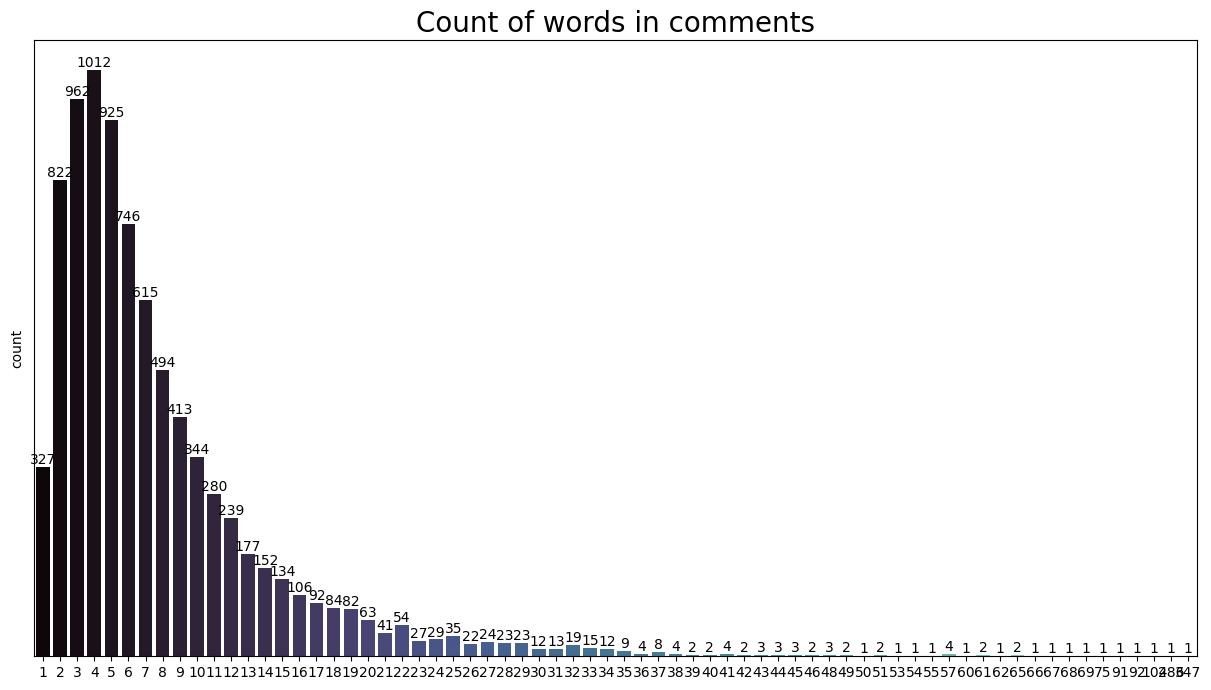

In [95]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='text_len', data=df, palette='mako')
plt.title('Count of words in comments', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()


In [33]:
X,Y = df1['comments_clean'],df1['class']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(231,) (231,) (100,) (100,)


In [51]:
from transformers import DistilBertTokenizer, DistilBertModel

In [42]:
model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')








































































































Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

In [44]:
#Save the model and tokenizer to a directory
model.save_pretrained('saved_model_dist')
tokenizer.save_pretrained('saved_model_dist')

('saved_model_dist\\tokenizer_config.json',
 'saved_model_dist\\special_tokens_map.json',
 'saved_model_dist\\vocab.txt',
 'saved_model_dist\\added_tokens.json')

In [45]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

# Convert data to numpy arrays
X_train_input_ids = np.array(train_encodings['input_ids'])
X_train_attention_masks = np.array(train_encodings['attention_mask'])

X_test_input_ids = np.array(test_encodings['input_ids'])
X_test_attention_masks = np.array(test_encodings['attention_mask'])

# Convert input to PyTorch tensors
X_train_input_ids = torch.tensor(train_encodings['input_ids'])
X_train_attention_masks = torch.tensor(train_encodings['attention_mask'])
X_test_input_ids = torch.tensor(test_encodings['input_ids'])
X_test_attention_masks = torch.tensor(test_encodings['attention_mask'])

# Get word embeddings
train_embeddings = model(X_train_input_ids, X_train_attention_masks)[0][:, 0, :]
test_embeddings = model(X_test_input_ids, X_test_attention_masks)[0][:, 0, :]

In [48]:
log_reg = LogisticRegression()


In [50]:
log_cv_score = cross_val_score(log_reg, train_embeddings.detach().numpy(), y_train, cv=5, scoring='f1_macro', n_jobs=-1)
mean_log_cv = np.mean(log_cv_score)
mean_log_cv


C:\Users\BIGNETWORK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


0.5581583386579522